Students:

- Ben Kabongo, M1 DS, 22210136

# Deep Learning - Lab Exercise 2

**WARNING:** you must have finished the first exercise before this one as you will re-use parts of the code.

In the first lab exercise, we built a simple linear classifier.
Although it can give reasonable results on the MNIST dataset (~92.5% of accuracy), deeper neural networks can achieve more the 99% accuracy.
However, it can quickly become really impracical to explicitly code forward and backward passes.
Hence, it is useful to rely on an auto-diff library where we specify the forward pass once, and the backward pass is automatically deduced from the computational graph structure.

In this lab exercise, we will build a small and simple auto-diff lib that mimics the autograd mechanism from Pytorch (of course, we will simplify a lot!)


In [1]:
# import libs that we will use
import os
import numpy as np
import matplotlib.pyplot as plt
import math

# To load the data we will use the script of Gaetan Marceau Caron
# You can download it from the course webiste and move it to the same directory that contains this ipynb file
import dataset_loader

%matplotlib inline

# Data

In [2]:
# Download mnist dataset 
if("mnist.pkl.gz" not in os.listdir(".")):
    # this link doesn't work any more,
    # seach on google for the file "mnist.pkl.gz"
    # and download it
    #!wget http://deeplearning.net/data/mnist/mnist.pkl.gz
    !wget https://github.com/mnielsen/neural-networks-and-deep-learning/raw/master/data/mnist.pkl.gz

# if you have it somewhere else, you can comment the lines above
# and overwrite the path below
mnist_path = "./mnist.pkl.gz"

In [3]:
# load the 3 splits
train_data, dev_data, test_data = dataset_loader.load_mnist(mnist_path)

label: 7


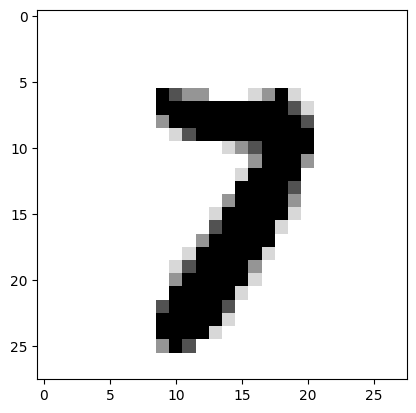

In [4]:
index = 900
label = train_data[1][index]
picture = train_data[0][index]

print("label: %i" % label)
plt.imshow(picture.reshape(28,28), cmap='Greys')

# Computation nodes

Instead of directly manipulating numpy arrays, we will manipulate abstraction that contains:
- a value (i.e. a numpy array)
- a bool indicating if we wish to compute the gradient with respect to the value
- the gradient with respect to the value
- the operation to call during backpropagation

There will be two kind of nodes:
- Tensor: a generic computation node
- Parameter: a computation node that is used to store parameters of the network. Parameters are always leaf nodes, i.e. they cannot be build from other computation nodes.

Our implementation of the backward pass will be really simple and incorrect in the general case (i.e. won't work with computation graph with loops).
We will just apply the derivative function for a given tensor and then call the ones of its antecedents, recursively.
This simple algorithm is good enough for this exercise.

Note that a real implementation of backprop will store temporary values during forward that can be used during backward to improve computation speed. We do not do that here.

In [5]:
class Tensor:
    def __init__(self, data, require_grad=False):
        # test type of data: should be np array
        if isinstance(data, float):
            data = np.array([data,])
        if type(data) != np.ndarray:
            raise RuntimeError("Input should be a numpy array")

        # store data for this tensor
        self.data = data
        self.require_grad = require_grad
        
        # this values should be set to enable autograd!
        self.gradient = None
        self.d = None
        self.backptr = None
        
    def zero_grad(self):
        """
        Set the gradient of thie tensor to 0
        """
        if self.require_grad:
            self.gradient = np.zeros_like(self.data)
            
    def accumulate_gradient(self, gradient):
        """
        Accumulte gradient for this tensor
        """
        if gradient.shape != self.data.shape:
            raise RuntimeError("Invalid gradient dimension")

        if self.gradient is None:
            self.gradient = np.copy(gradient)
        else:
            self.gradient += gradient
            
    def backward(self, g=None):
        """
        The backward pass!
        If g != None, then g is the gradient for the current node.
        i.e. g will be != None only for the loss output.
        
        You should call the function stored in self.d with correct arguments,
        and then recursively call the backward methods of tensors in the backptr list if:
        1. they require a gradient
        2. they are of type Tensor: check with isinstance(o, Tensor)
        """
        if not self.require_grad:  # stop right now if this node does not require a gradient
            return
        
        if g is not None:
            if isinstance(g, float):
                g = np.array([g])
            if type(g) != np.ndarray:
                raise RuntimeError("Gradient should be a numpy array")
            if g.shape != self.data.shape:
                raise RuntimeError("Gradient of different size than the value!")
                
            self.gradient = g

        if self.d is None:
            raise RuntimeError("Backward function not defined!")
        if self.backptr is None:
            raise RuntimeError("Backward graph not defined!")
        if self.gradient is None:
            raise RuntimeError("Gradient not defined!")
        
        self.d(self.backptr, self.gradient)
        for node in self.backptr:
            if isinstance(node, Tensor) and not isinstance(node, Parameter) and node.require_grad:
                node.backward()

In [6]:
class Parameter(Tensor):
    """
    This class will be used to store parameters of the network only!
    """
    def __init__(self, data, name="unamed"):
        super().__init__(data, require_grad=True)
        self.name = name
        
    def backward(self):
        raise RuntimeError("You cannot backprop from a Parameter node")

# Functions

Functions manipulate tensors and build the required information for autograd.
A function returns a Tensor that should have require_grad = True if at least of the arguments require a gradient.

In [7]:
def any_require_grad(l):
    """
    Input:
    - l: an iterable (e.g. a list)
    Ouput:
    - True if any tensor in the input requires a gradient
    """
    return any(t.require_grad for t in l)

In [8]:
# Here is an exemple with the ReLU
def relu(x):
    v = np.maximum(0, x.data)
    
    output = Tensor(v, require_grad=x.require_grad)
    output.d = backward_relu
    output.backptr = [x]
    
    return output

def backward_relu(backptr, g):
    x, = backptr
    
    # the gradient is accumulated in the arguments only if required
    if x.require_grad:
        x.accumulate_gradient(g * (x.data > 0))

In [9]:
def tanh(x):
    v = np.tanh(x.data)
    
    output = Tensor(v, require_grad=x.require_grad)
    output.d = backward_tanh
    output.backptr = [x]
    
    return output

def backward_tanh(backptr, g):
    x, = backptr
    
    # the gradient is accumulated in the arguments only if required
    if x.require_grad:
        grad = g * (1 - np.tanh(x.data) ** 2)
        x.accumulate_gradient(grad)

Next, we implement the affine transform operation.
You can reuse the code from the first lab exercise, with one major difference: you have to compute the gradient with respect to x too!

In [10]:
def affine_transform(W, b, x):
    z = W.data @ x.data + b.data
    
    output = Tensor(z, require_grad=any_require_grad([W, b, x]))
    output.backptr = [W, b, x]
    output.d = backward_affine_transform
    
    return output

def backward_affine_transform(backptr, g):
    W, b, x = backptr
    
    # the gradient is accumulated in the arguments only if required
    if W.require_grad:
        W.accumulate_gradient(np.outer(g, x.data))
    if b.require_grad:
        b.accumulate_gradient(g)
    if isinstance(x, Tensor) and x.require_grad:
        x.accumulate_gradient(W.data.T @ g)

In [11]:
# we use an underscore because this function does not manipulate tensors:
# it is exactly the same as in the previous exercise
def _softmax(x):
    x = np.array(x)
    exp = np.exp(x-x.max())
    return exp / exp.sum()

def nll(x, gold):
    v = -np.log(_softmax(x.data)[gold])

    output = Tensor(v, require_grad=x.require_grad)
    output.backptr = [x, gold]
    output.d = backward_nll

    return output

def backward_nll(backptr, g):
    x, gold = backptr

    if x.require_grad:
        mask = np.zeros(x.data.shape)
        mask[gold] = 1
        g_x = (_softmax(x.data) - mask) * g
        x.accumulate_gradient(g_x)

# Module

Neural networks or parts of neural networks will be stored in Modules.
They implement method to retrieve all parameters of the network and subnetwork.

In [12]:
class Module:
    def __init__(self):
        raise NotImplemented("")
        
    def parameters(self):
        ret = []
        for name in dir(self):
            o = self.__getattribute__(name)

            if type(o) is Parameter:
                ret.append(o)
            if isinstance(o, Module) or isinstance(o, ModuleList):
                ret.extend(o.parameters())
        return ret

# if you want to store a list of Parameters or Module,
# you must store them in a ModuleList instead of a python list,
# in order to collect the parameters correctly
class ModuleList(list):
    def parameters(self):
        ret = []
        for m in self:
            if type(m) is Parameter:
                ret.append(m)
            elif isinstance(m, Module) or isinstance(m, ModuleList):
                ret.extend(m.parameters())
        return ret

# Initialization and optimization

In [13]:
def zero_init(b):
    b[:] = 0.

def glorot_init(W):
    n_in, n_out = W.shape
    std = np.sqrt(2.0 / (n_in + n_out))
    W[:] = np.random.normal(0, std, size=(n_in, n_out))
    
# Look at slides for the formula!
def kaiming_init(W):
    n_in, n_out = W.shape
    std = np.sqrt(2.0 / n_in)
    W[:] = np.random.normal(0, std, size=(n_in, n_out))

In [14]:
# simple gradient descent optimizer
class SGD:
    def __init__(self, params, lr=0.1):
        self.params = params
        self.lr = lr
        
    def step(self):
        for p in self.params:
            p.data[:] = p.data - self.lr * p.gradient
        
    def zero_grad(self):
        for p in self.params:
            p.zero_grad()

# Networks and training loop

We first create a simple linear classifier, similar to the first lab exercise.

In [15]:
class LinearNetwork(Module):
    def __init__(self, dim_input, dim_output):
        # build the parameters
        self.W = Parameter(np.ndarray((dim_output, dim_input)), name="W")
        self.b = Parameter(np.ndarray((dim_output,)), name="b")
        
        self.init_parameters()
        
    def init_parameters(self):
        # init parameters of the network (i.e W and b)
        glorot_init(self.W.data)
        zero_init(self.b.data)
        
    def forward(self, x):
        return  affine_transform(self.W, self.b, x)

We will train several neural networks.
Therefore, we encapsulate the training loop in a function.

**warning**: you have to call optimizer.zero_grad() before each backward pass to reinitialize the gradient of the parameters!

In [16]:
import math

def training_loop(network, optimizer, train_data, dev_data, n_epochs=10):
    best_dev = -math.inf
    idx = np.arange(0, len(train_data[1]))

    all_loss = []
    all_valid_acc = []

    for epoch in range(n_epochs):
        np.random.shuffle(idx)

        # train
        loss = 0
        for i in idx:
            x = train_data[0][i]
            y = train_data[1][i]
            x_t = Tensor(x)
            # forward
            z = network.forward(x_t)
            loss_tensor = nll(z, y)
            loss += loss_tensor.data[0]
            # zero grad
            optimizer.zero_grad()
            # backward
            loss_tensor.backward(.1)
            # update
            optimizer.step()

        # eval
        dev_acc = 0
        for i in range(len(dev_data[1])):
            x = dev_data[0][i]
            y = dev_data[1][i]
            x_t = Tensor(x)
            # predict
            y_pred = network.forward(x_t).data.argmax()
            dev_acc += int(y_pred == y)
        dev_acc /= len(dev_data[1])
        print(f'Epoch {epoch + 1} : \tTrain Loss : {loss} \tValid Acc: {dev_acc}')
        all_loss.append(loss)
        all_valid_acc.append(dev_acc)

        if dev_acc > best_dev:
            best_dev = dev_acc
            optimizer.best_params = list(optimizer.params)

    return all_loss, all_valid_acc

In [17]:
dim_input = 28*28
dim_output = 10

network = LinearNetwork(dim_input, dim_output)
optimizer = SGD(network.parameters(), 0.01)

training_loop(network, optimizer, train_data, dev_data, n_epochs=10)
print()

Epoch 1 : 	Train Loss : 28882.175755378383 	Valid Acc: 0.9032
Epoch 2 : 	Train Loss : 18811.496555268393 	Valid Acc: 0.9114
Epoch 3 : 	Train Loss : 17231.227994827063 	Valid Acc: 0.9147
Epoch 4 : 	Train Loss : 16418.086521958223 	Valid Acc: 0.9168
Epoch 5 : 	Train Loss : 15886.220847681501 	Valid Acc: 0.9182
Epoch 6 : 	Train Loss : 15507.781740888575 	Valid Acc: 0.9189
Epoch 7 : 	Train Loss : 15199.298480420777 	Valid Acc: 0.9201
Epoch 8 : 	Train Loss : 14977.391235820114 	Valid Acc: 0.9205
Epoch 9 : 	Train Loss : 14773.568868018929 	Valid Acc: 0.9223
Epoch 10 : 	Train Loss : 14617.409558412975 	Valid Acc: 0.9222



In [18]:
for param in optimizer.best_params:
    print(param.name, param.data.shape)

W (10, 784)
b (10,)


In [19]:
# Test evaluation
network = LinearNetwork(dim_input, dim_output)
network.W = optimizer.best_params[0]
network.b = optimizer.best_params[1]

test_acc = 0
for i in range(len(test_data[1])):
    x = test_data[0][i]
    y = test_data[1][i]
    x_t = Tensor(x)
    y_pred = affine_transform(optimizer.best_params[0], optimizer.best_params[1], x_t).data.argmax()
    test_acc += int(y_pred == y)
test_acc /= len(dev_data[1])
print(f'Test acc {test_acc}')

Test acc 0.9216


After you finished the linear network, you can move to a deep network!

In [20]:
class DeepNetwork(Module):
    def __init__(self, dim_input, dim_output, hidden_dim, n_layers, use_tanh=False):
        self.W = ModuleList()
        self.b = ModuleList()
        
        assert n_layers >= 1
        self.n_layers = n_layers
        self.activation = tanh if use_tanh else relu

        self.W.append(Parameter(np.ndarray((hidden_dim, dim_input)), name="W1"))
        self.b.append(Parameter(np.ndarray((hidden_dim,)), name="b1"))

        for i in range(2, n_layers+1):
            self.W.append(Parameter(np.ndarray((hidden_dim, hidden_dim)), name=f"W{i}"))
            self.b.append(Parameter(np.ndarray((hidden_dim,)), name=f"b{i}"))
        
        self.output_proj = Parameter(np.ndarray((dim_output, hidden_dim)), name=f"W{n_layers+1}")
        self.output_bias = Parameter(np.ndarray((dim_output,)), name=f"b{n_layers+1}")
        
        self.init_parameters()
        
    def init_parameters(self):
        for i in range(self.n_layers):
            glorot_init(self.W[i].data)
            zero_init(self.b[i].data)
        glorot_init(self.output_proj.data)
        zero_init(self.output_bias.data)

    def forward(self, x):
        for i in range(self.n_layers):
            x = affine_transform(self.W[i], self.b[i], x)
            x = self.activation(x)
        x = affine_transform(self.output_proj, self.output_bias, x)
        return x

In [21]:
dim_input = 28*28
dim_output = 10

network = DeepNetwork(dim_input, dim_output, 100, 2)
optimizer = SGD(network.parameters(), 0.01)

training_loop(network, optimizer, train_data, dev_data, n_epochs=5)
print()

Epoch 1 : 	Train Loss : 21457.37633778506 	Valid Acc: 0.933
Epoch 2 : 	Train Loss : 10725.54875001142 	Valid Acc: 0.9512
Epoch 3 : 	Train Loss : 7991.096826706343 	Valid Acc: 0.9604
Epoch 4 : 	Train Loss : 6382.8545880555075 	Valid Acc: 0.9645
Epoch 5 : 	Train Loss : 5291.535915941409 	Valid Acc: 0.9694



In [22]:
for param in optimizer.best_params:
    print(param.name, param.data.shape)

W1 (100, 784)
W2 (100, 100)
b1 (100,)
b2 (100,)
b3 (10,)
W3 (10, 100)


In [23]:
# Test evaluation
network = DeepNetwork(dim_input, dim_output, 100, 2)
network.W = optimizer.best_params[:2]
network.b = optimizer.best_params[2:4]
network.output_bias = optimizer.best_params[4]
network.output_proj = optimizer.best_params[5]

test_acc = 0
for i in range(len(test_data[1])):
    x = test_data[0][i]
    y = test_data[1][i]
    x_t = Tensor(x)
    y_pred = network.forward(x_t).data.argmax()
    test_acc += int(y_pred == y)
test_acc /= len(dev_data[1])
print(f'Test acc {test_acc}')

Test acc 0.9671


In [24]:
dim_input = 28*28
dim_output = 10

network = DeepNetwork(dim_input, dim_output, 100, 2, True)
optimizer = SGD(network.parameters(), 0.01)

training_loop(network, optimizer, train_data, dev_data, n_epochs=5)
print()

Epoch 1 : 	Train Loss : 21923.668778396455 	Valid Acc: 0.9248
Epoch 2 : 	Train Loss : 12549.398555506374 	Valid Acc: 0.9408
Epoch 3 : 	Train Loss : 9892.481043312326 	Valid Acc: 0.9528
Epoch 4 : 	Train Loss : 8126.3478906400405 	Valid Acc: 0.9573
Epoch 5 : 	Train Loss : 6917.426062725272 	Valid Acc: 0.9616



In [25]:
for param in optimizer.best_params:
    print(param.name, param.data.shape)

W1 (100, 784)
W2 (100, 100)
b1 (100,)
b2 (100,)
b3 (10,)
W3 (10, 100)


In [26]:
# Test evaluation
network = DeepNetwork(dim_input, dim_output, 100, 2, True)
network.W = optimizer.best_params[:2]
network.b = optimizer.best_params[2:4]
network.output_bias = optimizer.best_params[4]
network.output_proj = optimizer.best_params[5]

test_acc = 0
for i in range(len(test_data[1])):
    x = test_data[0][i]
    y = test_data[1][i]
    x_t = Tensor(x)
    y_pred = network.forward(x_t).data.argmax()
    test_acc += int(y_pred == y)
test_acc /= len(dev_data[1])
print(f'Test acc {test_acc}')

Test acc 0.9589


In [27]:
dim_input = 28*28
dim_output = 10

network = DeepNetwork(dim_input, dim_output, 100, 5, True)
optimizer = SGD(network.parameters(), 0.01)

training_loop(network, optimizer, train_data, dev_data, n_epochs=5)
print()

Epoch 1 : 	Train Loss : 19603.663035985337 	Valid Acc: 0.9386
Epoch 2 : 	Train Loss : 9845.035561752567 	Valid Acc: 0.9567
Epoch 3 : 	Train Loss : 7152.595023806055 	Valid Acc: 0.963
Epoch 4 : 	Train Loss : 5612.689480031973 	Valid Acc: 0.9656
Epoch 5 : 	Train Loss : 4529.2820997012 	Valid Acc: 0.9696



In [28]:
for param in optimizer.best_params:
    print(param.name, param.data.shape)

W1 (100, 784)
W2 (100, 100)
W3 (100, 100)
W4 (100, 100)
W5 (100, 100)
b1 (100,)
b2 (100,)
b3 (100,)
b4 (100,)
b5 (100,)
b6 (10,)
W6 (10, 100)


In [29]:
# Test evaluation
network = DeepNetwork(dim_input, dim_output, 100, 5, True)
network.W = optimizer.best_params[:5]
network.b = optimizer.best_params[5:10]
network.output_bias = optimizer.best_params[10]
network.output_proj = optimizer.best_params[11]

test_acc = 0
for i in range(len(test_data[1])):
    x = test_data[0][i]
    y = test_data[1][i]
    x_t = Tensor(x)
    y_pred = network.forward(x_t).data.argmax()
    test_acc += int(y_pred == y)
test_acc /= len(dev_data[1])
print(f'Test acc {test_acc}')

Test acc 0.9681


## Bonus

You can try to implement a momentum SGD optimizer! Note that you have to keep track of the velocity for each parameter in the optimizer.


## Experimentations

In [30]:
# linear
def linear(lr=.01, n_epochs=5):
    print(f'\nlr={lr} n_epochs={n_epochs} -------------------------------')

    dim_input = 28*28
    dim_output = 10

    network = LinearNetwork(dim_input, dim_output)
    optimizer = SGD(network.parameters(), lr)

    all_loss, all_valid_acc = training_loop(network, optimizer, train_data, dev_data, n_epochs=n_epochs)
    
    # Test evaluation
    network = LinearNetwork(dim_input, dim_output)
    network.W = optimizer.best_params[0]
    network.b = optimizer.best_params[1]

    test_acc = 0
    for i in range(len(test_data[1])):
        x = test_data[0][i]
        y = test_data[1][i]
        x_t = Tensor(x)
        y_pred = affine_transform(optimizer.best_params[0], optimizer.best_params[1], x_t).data.argmax()
        test_acc += int(y_pred == y)
    test_acc /= len(dev_data[1])
    print(f'Test acc : {test_acc}')

    return all_loss, all_valid_acc, test_acc

In [31]:
# learning rate

lrs = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
n_epochs = 10

all_loss_lrs = []
all_valid_acc_lrs = []
all_test_acc_lrs = []

for lr in lrs:
    all_loss, all_valid_acc, test_acc = linear(lr=lr, n_epochs=n_epochs)
    all_loss_lrs.append(all_loss)
    all_valid_acc_lrs.append(all_valid_acc)
    all_test_acc_lrs.append(test_acc)
    print()


lr=0.0001 n_epochs=10 -------------------------------
Epoch 1 : 	Train Loss : 109820.60185060666 	Valid Acc: 0.4386
Epoch 2 : 	Train Loss : 89079.35421342171 	Valid Acc: 0.6587
Epoch 3 : 	Train Loss : 75429.2910774485 	Valid Acc: 0.739
Epoch 4 : 	Train Loss : 65905.45306132591 	Valid Acc: 0.7762
Epoch 5 : 	Train Loss : 59043.89424008968 	Valid Acc: 0.8004
Epoch 6 : 	Train Loss : 53922.91060498647 	Valid Acc: 0.8161
Epoch 7 : 	Train Loss : 49973.936749366665 	Valid Acc: 0.8276
Epoch 8 : 	Train Loss : 46841.252056130295 	Valid Acc: 0.8353
Epoch 9 : 	Train Loss : 44295.663072180556 	Valid Acc: 0.8417
Epoch 10 : 	Train Loss : 42184.877880959204 	Valid Acc: 0.8463
Test acc : 0.837


lr=0.001 n_epochs=10 -------------------------------
Epoch 1 : 	Train Loss : 62824.61502672266 	Valid Acc: 0.8514
Epoch 2 : 	Train Loss : 35246.87499481058 	Valid Acc: 0.8734
Epoch 3 : 	Train Loss : 29053.910645044965 	Valid Acc: 0.8847
Epoch 4 : 	Train Loss : 26079.49349276105 	Valid Acc: 0.8887
Epoch 5 : 	Tra

<ipython-input-11-5decd553a3a7>:9: RuntimeWarning: divide by zero encountered in log
  v = -np.log(_softmax(x.data)[gold])


Epoch 3 : 	Train Loss : inf 	Valid Acc: 0.8611
Epoch 4 : 	Train Loss : inf 	Valid Acc: 0.8832
Epoch 5 : 	Train Loss : inf 	Valid Acc: 0.8942
Epoch 6 : 	Train Loss : 466559.03897445963 	Valid Acc: 0.8568
Epoch 7 : 	Train Loss : inf 	Valid Acc: 0.8968
Epoch 8 : 	Train Loss : inf 	Valid Acc: 0.8487
Epoch 9 : 	Train Loss : 451370.8745678047 	Valid Acc: 0.9007
Epoch 10 : 	Train Loss : inf 	Valid Acc: 0.8701
Test acc : 0.8581



In [32]:
all_loss_lrs = np.array(all_loss_lrs)
all_valid_acc_lrs = np.array(all_valid_acc_lrs)
all_test_acc_lrs = np.array(all_test_acc_lrs)

In [33]:
plt.style.use('seaborn-whitegrid')

<ipython-input-33-adcf1482bdd0>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


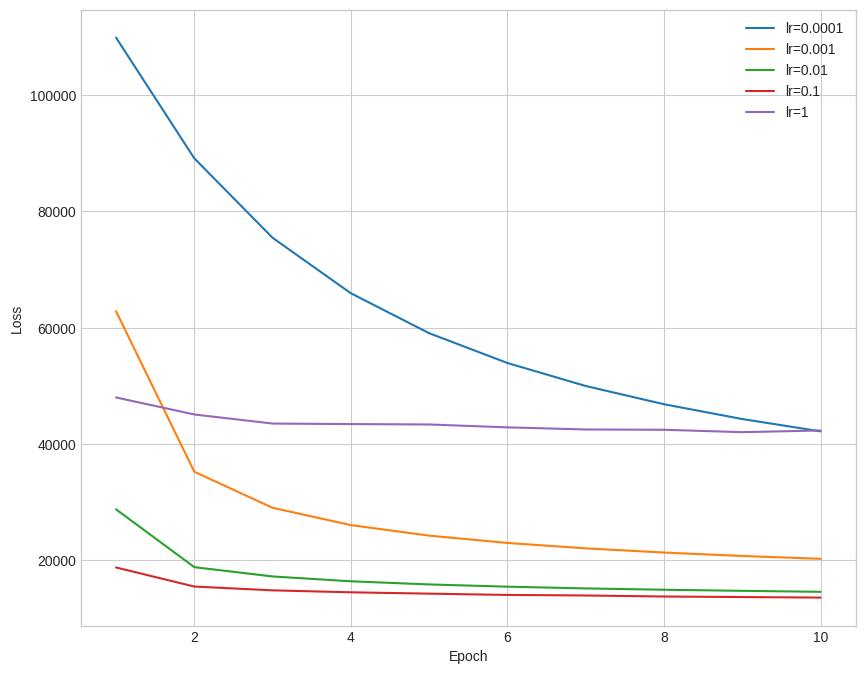

In [34]:
# lr loss
plt.figure(figsize=(10, 8))
for i, lr in enumerate(lrs[:-1]):
    plt.plot(np.arange(1, 1 + n_epochs), all_loss_lrs[i], label=f'lr={lr}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

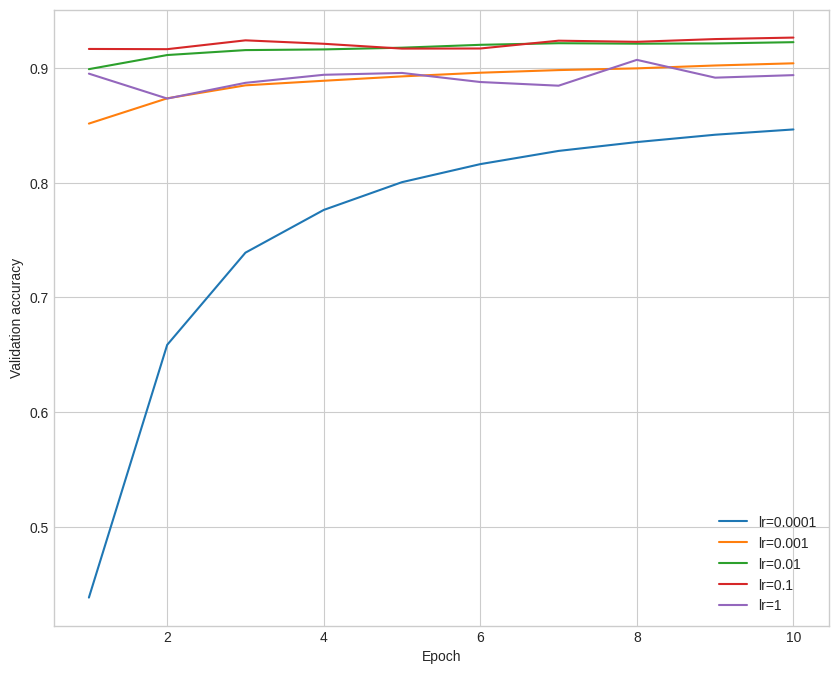

In [35]:
# lr validation accuracy
plt.figure(figsize=(10, 8))
for i, lr in enumerate(lrs[:-1]):
    plt.plot(np.arange(1, 1 + n_epochs), all_valid_acc_lrs[i], label=f'lr={lr}')
plt.xlabel('Epoch')
plt.ylabel('Validation accuracy')
plt.legend()
plt.show()

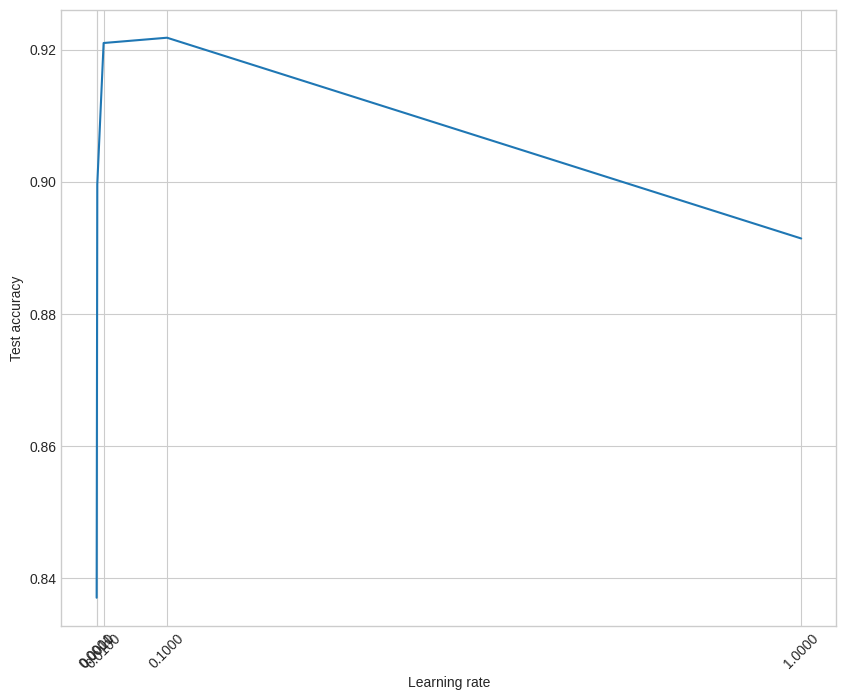

In [36]:
# lr test accuracy
plt.figure(figsize=(10, 8))
plt.plot(lrs[:-1], all_test_acc_lrs[:-1])
plt.xlabel('Learning rate')
plt.ylabel('Test accuracy')
plt.xticks(lrs[:-1], rotation=45)
plt.show()

In [37]:
# nb of epochs

lr = 1e-2
ns_epochs = [2, 5, 10, 20]

all_test_acc_n_epochs = []

for n_epochs in ns_epochs:
    _, _, test_acc = linear(lr=lr, n_epochs=n_epochs)
    all_test_acc_n_epochs.append(test_acc)
    print()


lr=0.01 n_epochs=2 -------------------------------
Epoch 1 : 	Train Loss : 28779.347050132434 	Valid Acc: 0.9046
Epoch 2 : 	Train Loss : 18781.797630199955 	Valid Acc: 0.9095
Test acc : 0.9093


lr=0.01 n_epochs=5 -------------------------------
Epoch 1 : 	Train Loss : 28874.084465879165 	Valid Acc: 0.903
Epoch 2 : 	Train Loss : 18813.021280389803 	Valid Acc: 0.9107
Epoch 3 : 	Train Loss : 17223.97189425011 	Valid Acc: 0.9156
Epoch 4 : 	Train Loss : 16397.316978780065 	Valid Acc: 0.9168
Epoch 5 : 	Train Loss : 15866.282716792903 	Valid Acc: 0.9167
Test acc : 0.9162


lr=0.01 n_epochs=10 -------------------------------
Epoch 1 : 	Train Loss : 28757.825399219706 	Valid Acc: 0.9003
Epoch 2 : 	Train Loss : 18852.362646362963 	Valid Acc: 0.91
Epoch 3 : 	Train Loss : 17245.64534326431 	Valid Acc: 0.9144
Epoch 4 : 	Train Loss : 16413.169419556776 	Valid Acc: 0.9181
Epoch 5 : 	Train Loss : 15882.153995075281 	Valid Acc: 0.9186
Epoch 6 : 	Train Loss : 15495.707082619223 	Valid Acc: 0.9182
Epoc

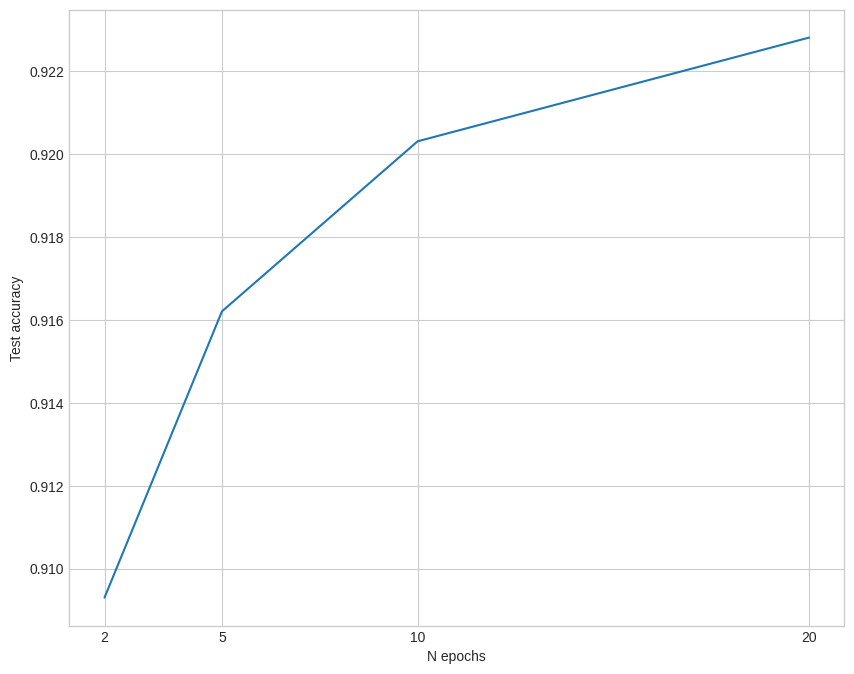

In [38]:
# n_epochs test accuracy
plt.figure(figsize=(10, 8))
plt.plot(ns_epochs, all_test_acc_n_epochs)
plt.xlabel('N epochs')
plt.ylabel('Test accuracy')
plt.xticks(ns_epochs)
plt.show()

In [39]:
# deep
def deep(lr=.01, n_epochs=5, hidden_dim=100, n_layers=2, use_tanh=False):
    print(f'\nlr={lr} n_epochs={n_epochs} hidden_dim={hidden_dim} n_layers={n_layers} tanh={use_tanh}')
    print('-----------------------------------------------')

    dim_input = 28*28
    dim_output = 10

    network = DeepNetwork(dim_input, dim_output, hidden_dim, n_layers, use_tanh)
    optimizer = SGD(network.parameters(), lr)

    all_loss, all_valid_acc = training_loop(network, optimizer, train_data, dev_data, n_epochs=n_epochs)
    
    # Test evaluation
    network = DeepNetwork(dim_input, dim_output, hidden_dim, n_layers, use_tanh)
    network.W = optimizer.best_params[:n_layers]
    network.b = optimizer.best_params[n_layers:2*n_layers]
    network.output_bias = optimizer.best_params[2*n_layers]
    network.output_proj = optimizer.best_params[2*n_layers+1]

    test_acc = 0
    for i in range(len(test_data[1])):
        x = test_data[0][i]
        y = test_data[1][i]
        x_t = Tensor(x)
        y_pred = network.forward(x_t).data.argmax()
        test_acc += int(y_pred == y)
    test_acc /= len(dev_data[1])
    print(f'Test acc {test_acc}')

    return all_loss, all_valid_acc, test_acc

In [40]:
# learning rate

lrs = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
n_epochs = 5
hidden_dim = 100
n_layers = 2
use_tanh = False

all_loss_lrs = []
all_valid_acc_lrs = []
all_test_acc_lrs = []

for lr in lrs:
    all_loss, all_valid_acc, test_acc = deep(lr=lr, n_epochs=n_epochs, hidden_dim=hidden_dim, n_layers=n_layers, use_tanh=use_tanh)
    all_loss_lrs.append(all_loss)
    all_valid_acc_lrs.append(all_valid_acc)
    all_test_acc_lrs.append(test_acc)
    print()


lr=0.0001 n_epochs=5 hidden_dim=100 n_layers=2 tanh=False
-----------------------------------------------
Epoch 1 : 	Train Loss : 112582.43486662133 	Valid Acc: 0.2842
Epoch 2 : 	Train Loss : 100294.9217390637 	Valid Acc: 0.5331
Epoch 3 : 	Train Loss : 88422.11202732759 	Valid Acc: 0.6292
Epoch 4 : 	Train Loss : 76189.8611085597 	Valid Acc: 0.6825
Epoch 5 : 	Train Loss : 64567.555655118755 	Valid Acc: 0.7385
Test acc 0.7255


lr=0.001 n_epochs=5 hidden_dim=100 n_layers=2 tanh=False
-----------------------------------------------
Epoch 1 : 	Train Loss : 65551.8889292717 	Valid Acc: 0.8532
Epoch 2 : 	Train Loss : 25968.640263236706 	Valid Acc: 0.89
Epoch 3 : 	Train Loss : 19859.064808287294 	Valid Acc: 0.906
Epoch 4 : 	Train Loss : 17462.02027626368 	Valid Acc: 0.9127
Epoch 5 : 	Train Loss : 16026.384647656889 	Valid Acc: 0.9198
Test acc 0.9172


lr=0.01 n_epochs=5 hidden_dim=100 n_layers=2 tanh=False
-----------------------------------------------
Epoch 1 : 	Train Loss : 23182.60238539

<ipython-input-11-5decd553a3a7>:9: RuntimeWarning: divide by zero encountered in log
  v = -np.log(_softmax(x.data)[gold])


Epoch 1 : 	Train Loss : inf 	Valid Acc: 0.1009
Epoch 2 : 	Train Loss : 127030.86560355076 	Valid Acc: 0.099
Epoch 3 : 	Train Loss : 127084.90737504682 	Valid Acc: 0.0983
Epoch 4 : 	Train Loss : 126939.4537451039 	Valid Acc: 0.0961
Epoch 5 : 	Train Loss : 126935.5730261259 	Valid Acc: 0.0961
Test acc 0.1009



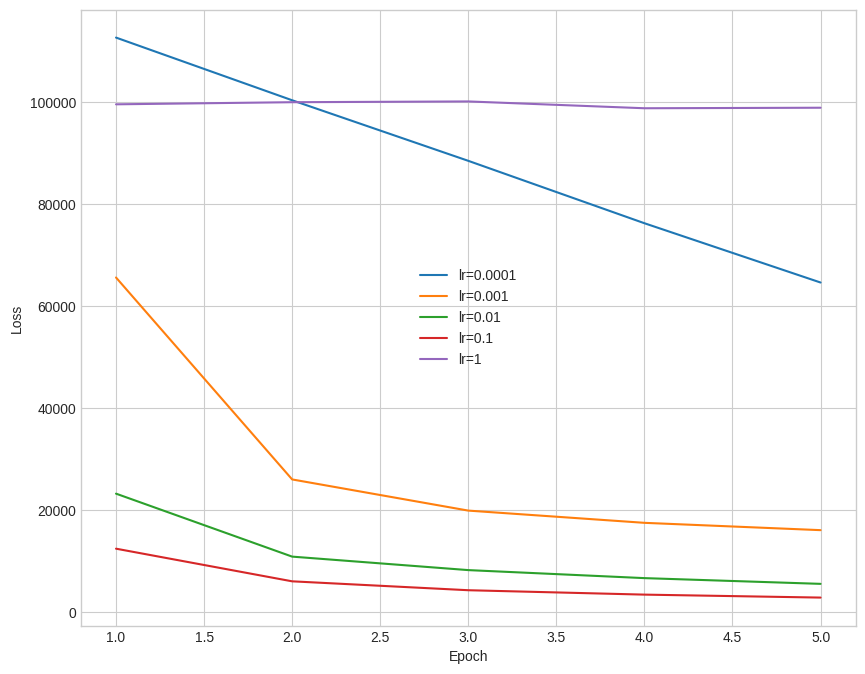

In [41]:
# lr loss
plt.figure(figsize=(10, 8))
for i, lr in enumerate(lrs[:-1]):
    plt.plot(np.arange(1, 1 + n_epochs), all_loss_lrs[i], label=f'lr={lr}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

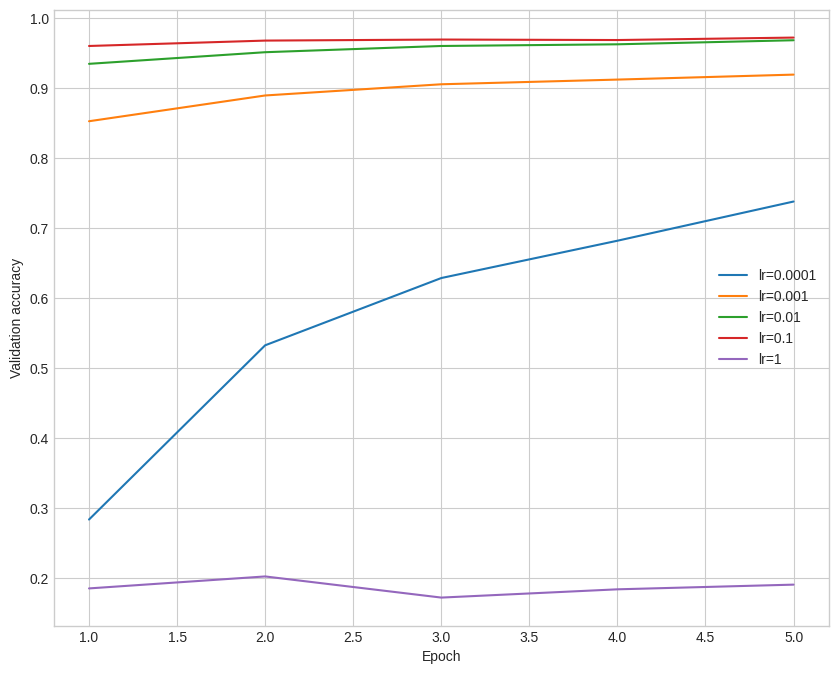

In [42]:
# lr loss
plt.figure(figsize=(10, 8))
for i, lr in enumerate(lrs[:-1]):
    plt.plot(np.arange(1, 1 + n_epochs), all_valid_acc_lrs[i], label=f'lr={lr}')
plt.xlabel('Epoch')
plt.ylabel('Validation accuracy')
plt.legend()
plt.show()

In [43]:
# n_layers

lr = 1e-2
n_epochs = 10
hidden_dim = 100
ns_layers = [2, 3, 4, 5, 6]
use_tanh = True

all_loss_ns_layers = []
all_valid_acc_ns_layers = []
all_test_acc_ns_layers = []

for n_layers in ns_layers:
    all_loss, all_valid_acc, test_acc = deep(lr=lr, n_epochs=n_epochs, hidden_dim=hidden_dim, n_layers=n_layers, use_tanh=use_tanh)
    all_loss_ns_layers.append(all_loss)
    all_valid_acc_ns_layers.append(all_valid_acc)
    all_test_acc_ns_layers.append(test_acc)
    print()


lr=0.01 n_epochs=10 hidden_dim=100 n_layers=2 tanh=True
-----------------------------------------------
Epoch 1 : 	Train Loss : 21205.532746380562 	Valid Acc: 0.9281
Epoch 2 : 	Train Loss : 12349.431471247875 	Valid Acc: 0.9427
Epoch 3 : 	Train Loss : 9764.920019007377 	Valid Acc: 0.9523
Epoch 4 : 	Train Loss : 8063.231890451862 	Valid Acc: 0.9575
Epoch 5 : 	Train Loss : 6890.4170540341365 	Valid Acc: 0.9622
Epoch 6 : 	Train Loss : 5966.796114674661 	Valid Acc: 0.9653
Epoch 7 : 	Train Loss : 5252.979682681724 	Valid Acc: 0.9666
Epoch 8 : 	Train Loss : 4665.5299994787965 	Valid Acc: 0.9667
Epoch 9 : 	Train Loss : 4171.4887783801305 	Valid Acc: 0.9704
Epoch 10 : 	Train Loss : 3737.6069573842283 	Valid Acc: 0.9695
Test acc 0.9702


lr=0.01 n_epochs=10 hidden_dim=100 n_layers=3 tanh=True
-----------------------------------------------
Epoch 1 : 	Train Loss : 20670.21709087521 	Valid Acc: 0.9307
Epoch 2 : 	Train Loss : 11029.823584752197 	Valid Acc: 0.9531
Epoch 3 : 	Train Loss : 8323.1720

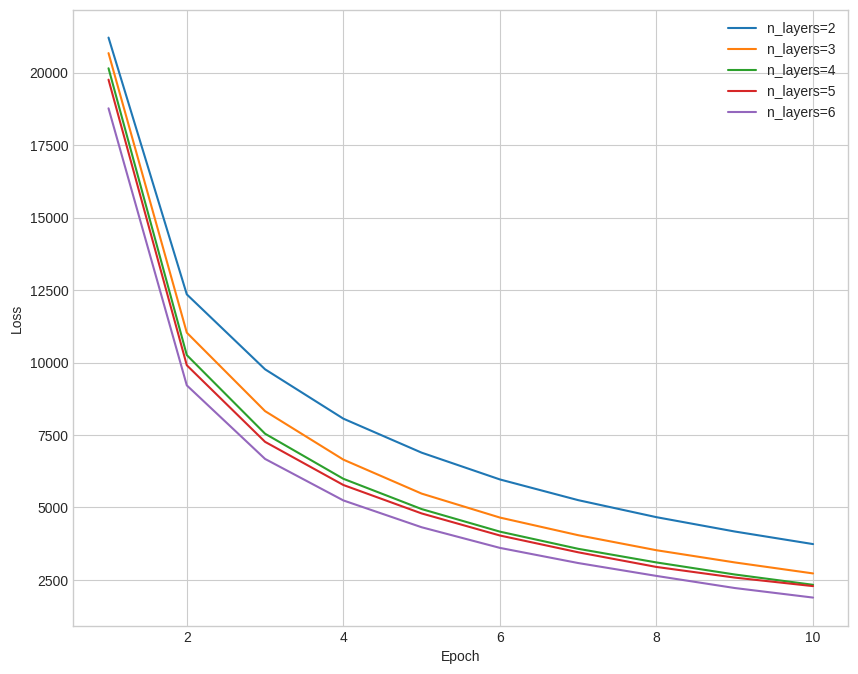

In [44]:
# n_layers loss
plt.figure(figsize=(10, 8))
for i, n_layers in enumerate(ns_layers):
    plt.plot(np.arange(1, 1 + n_epochs), all_loss_ns_layers[i], label=f'n_layers={n_layers}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

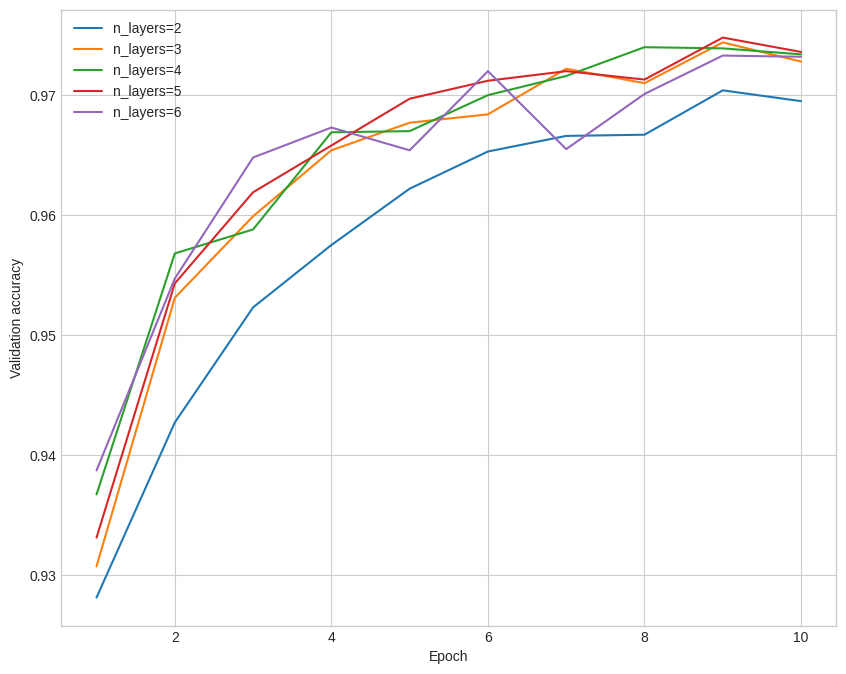

In [45]:
# n_layers loss
plt.figure(figsize=(10, 8))
for i, n_layers in enumerate(ns_layers):
    plt.plot(np.arange(1, 1 + n_epochs), all_valid_acc_ns_layers[i], label=f'n_layers={n_layers}')
plt.xlabel('Epoch')
plt.ylabel('Validation accuracy')
plt.legend()
plt.show()

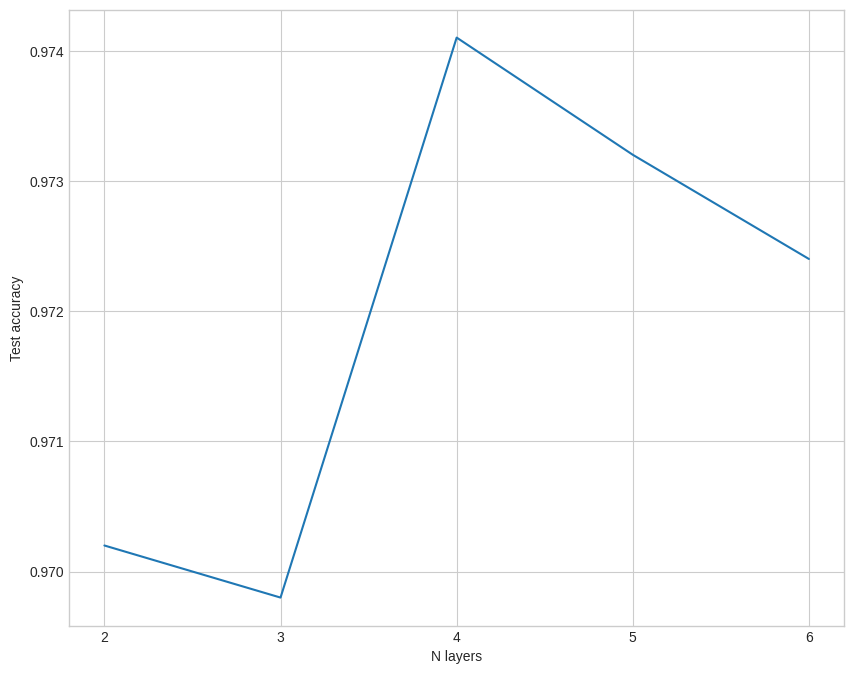

In [46]:
# n_layers test accuracy
plt.figure(figsize=(10, 8))
plt.plot(ns_layers, all_test_acc_ns_layers)
plt.xlabel('N layers')
plt.ylabel('Test accuracy')
plt.xticks(ns_layers)
plt.show()

In [47]:
# hidden_dim

lr = 1e-2
n_epochs = 10
hidden_dims = [10, 20, 50, 100, 200]
n_layers = 3
use_tanh = True

all_loss_hidden_dims = []
all_valid_acc_hidden_dims = []
all_test_acc_hidden_dims = []

for hidden_dim in hidden_dims:
    all_loss, all_valid_acc, test_acc = deep(lr=lr, n_epochs=n_epochs, hidden_dim=hidden_dim, n_layers=n_layers, use_tanh=use_tanh)
    all_loss_hidden_dims.append(all_loss)
    all_valid_acc_hidden_dims.append(all_valid_acc)
    all_test_acc_hidden_dims.append(test_acc)
    print()


lr=0.01 n_epochs=10 hidden_dim=10 n_layers=3 tanh=True
-----------------------------------------------
Epoch 1 : 	Train Loss : 41848.8964119896 	Valid Acc: 0.8967
Epoch 2 : 	Train Loss : 18824.950770817915 	Valid Acc: 0.9187
Epoch 3 : 	Train Loss : 15312.590823962957 	Valid Acc: 0.9292
Epoch 4 : 	Train Loss : 13509.443019611532 	Valid Acc: 0.9343
Epoch 5 : 	Train Loss : 12349.303331107241 	Valid Acc: 0.9428
Epoch 6 : 	Train Loss : 11500.440408549604 	Valid Acc: 0.9426
Epoch 7 : 	Train Loss : 10982.505458531685 	Valid Acc: 0.9427
Epoch 8 : 	Train Loss : 10562.929011236742 	Valid Acc: 0.943
Epoch 9 : 	Train Loss : 10197.914724332042 	Valid Acc: 0.9441
Epoch 10 : 	Train Loss : 9978.424573173024 	Valid Acc: 0.945
Test acc 0.9408


lr=0.01 n_epochs=10 hidden_dim=20 n_layers=3 tanh=True
-----------------------------------------------
Epoch 1 : 	Train Loss : 29793.456272921132 	Valid Acc: 0.912
Epoch 2 : 	Train Loss : 14252.62278250632 	Valid Acc: 0.934
Epoch 3 : 	Train Loss : 11218.27010425

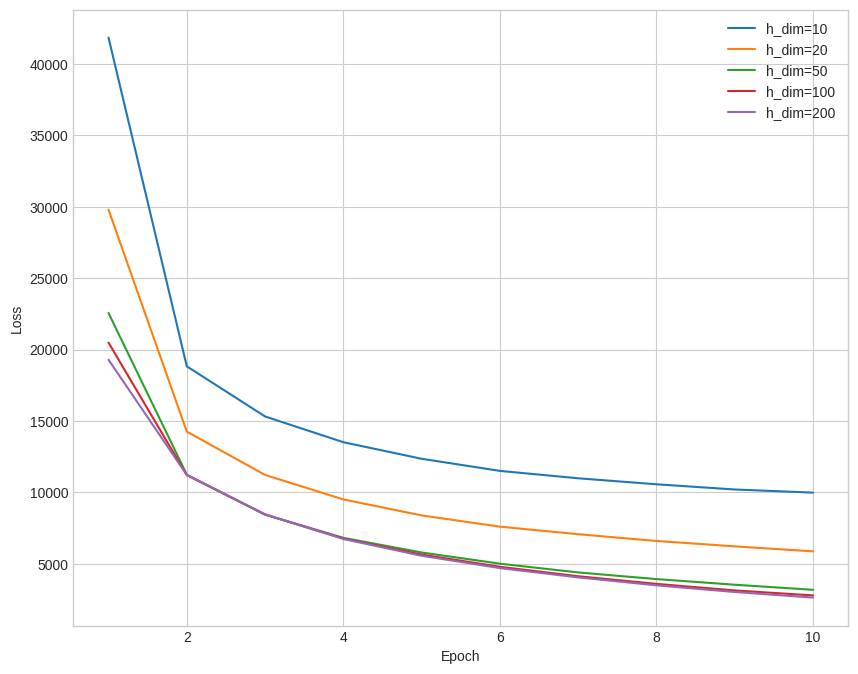

In [48]:
# hidden_dim loss
plt.figure(figsize=(10, 8))
for i, hidden_dim in enumerate(hidden_dims):
    plt.plot(np.arange(1, 1 + n_epochs), all_loss_hidden_dims[i], label=f'h_dim={hidden_dim}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

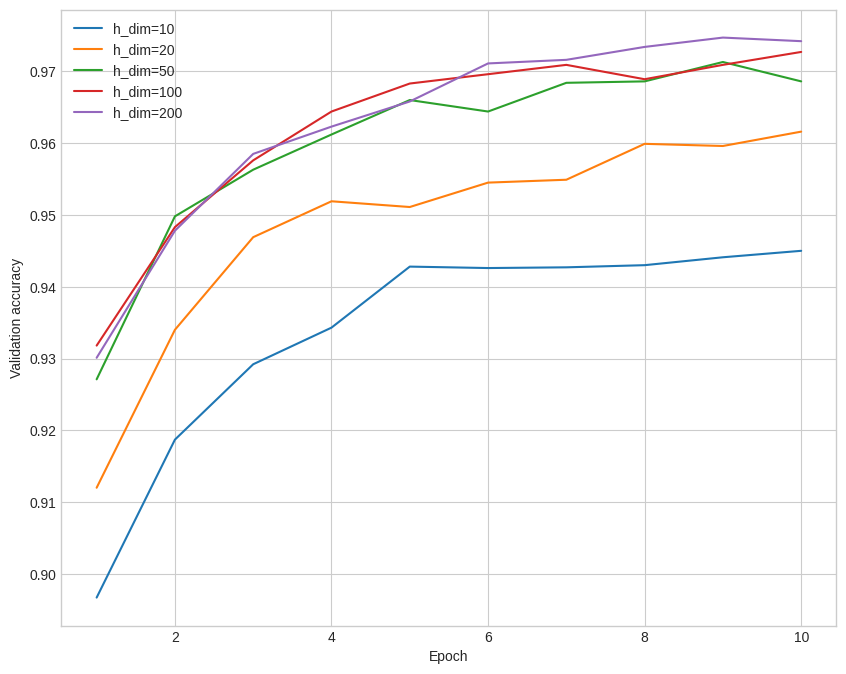

In [49]:
# hidden_dim loss
plt.figure(figsize=(10, 8))
for i, hidden_dim in enumerate(hidden_dims):
    plt.plot(np.arange(1, 1 + n_epochs), all_valid_acc_hidden_dims[i], label=f'h_dim={hidden_dim}')
plt.xlabel('Epoch')
plt.ylabel('Validation accuracy')
plt.legend()
plt.show()

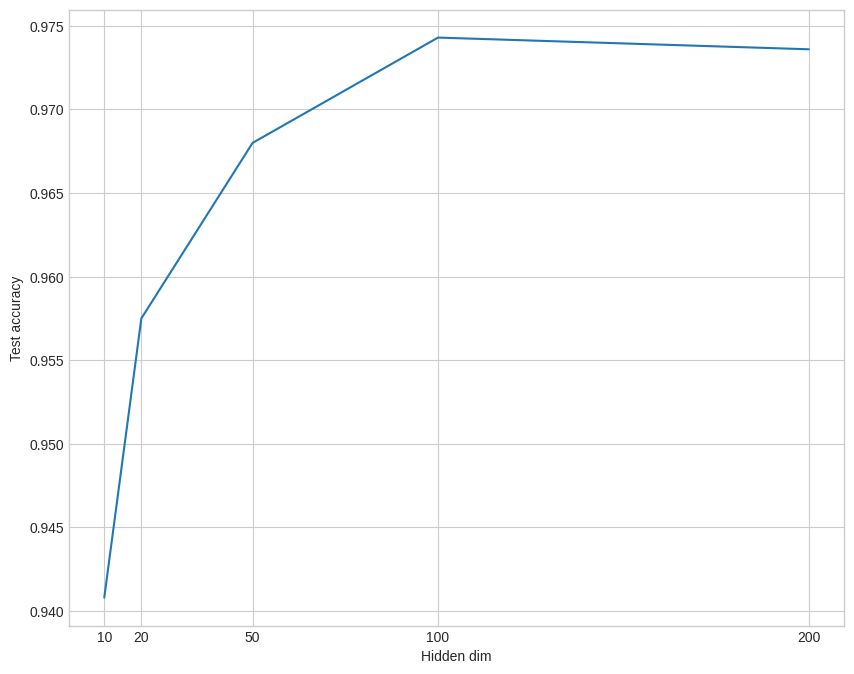

In [50]:
# hidden_dim test accuracy
plt.figure(figsize=(10, 8))
plt.plot(hidden_dims, all_test_acc_hidden_dims)
plt.xlabel('Hidden dim')
plt.ylabel('Test accuracy')
plt.xticks(hidden_dims)
plt.show()